In [372]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

df = pd.read_csv("heart_disease_health_indicators_BRFSS2015.csv")


In [373]:
df['Diabetes'] = df['Diabetes'].replace(2, 1)

# construct Y column
df['Y'] = df['HeartDiseaseorAttack'].astype(int).astype(str) + ',' + df['Diabetes'].astype(int).astype(str) + ',' + df['Stroke'].astype(int).astype(str)

In [374]:
print("Dimensions of the dataset : ", df.shape)
df['Y'].value_counts()

Dimensions of the dataset :  (253680, 23)


Y
0,0,0    193793
0,1,0     29639
1,0,0     13151
1,1,0      6805
0,0,1      4559
1,0,1      2200
0,1,1      1796
1,1,1      1737
Name: count, dtype: int64

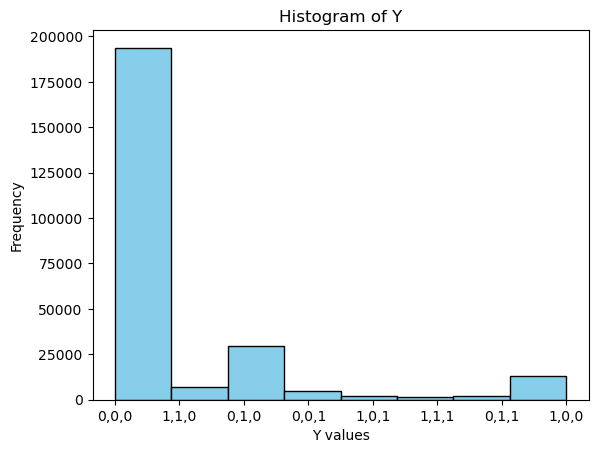

In [375]:
plt.hist(df['Y'], bins=8, color='skyblue', edgecolor='black')
plt.title('Histogram of Y')
plt.xlabel('Y values')
plt.ylabel('Frequency')
plt.show()

In [376]:
df['Age'].unique()

array([ 9.,  7., 11., 10.,  8., 13.,  4.,  6.,  2., 12.,  5.,  1.,  3.])

In [395]:
print(df.columns)

Index(['HeartDiseaseorAttack', 'HighBP', 'HighChol', 'CholCheck', 'BMI',
       'Smoker', 'Stroke', 'Diabetes', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income',
       'Y', 'Age_5Groups'],
      dtype='object')


In [377]:
def create_age_groups(age):
    if age in [1, 2, 3]:
        return 'Group1(1-3)'
    elif age in [4, 5, 6]:
        return 'Group2(4-6)'
    elif age in [7, 8, 9]:
        return 'Group3(7-9)'
    elif age in [10, 11]:
        return 'Group4(10-11)'
    elif age in [12, 13]:
        return 'Group5(12-13)'
    else:
        print('Unknown value')


df['Age_5Groups'] = df['Age'].apply(create_age_groups)



In [378]:
df['Age_5Groups'].value_counts()

Age_5Groups
Group3(7-9)      90390
Group4(10-11)    55727
Group2(4-6)      49799
Group5(12-13)    33343
Group1(1-3)      24421
Name: count, dtype: int64

In [379]:
def one_hist(column_name):
    group_counts = df[column_name].value_counts()

    # index gives the name of the class
    labels, counts = zip(*sorted(zip(group_counts.index, group_counts)))

    plt.hist(df[column_name], bins=np.arange(len(labels)+1)-0.5, color='skyblue', edgecolor='black')

    plt.xticks(range(len(labels)), labels, rotation=45)

    plt.xlabel(column_name)
    plt.ylabel('Frequency')

    plt.show()


# Test

# Test end

In [381]:
def stacked_hist(df, x_var, stack_var, drop_Y000=False):
    # calculate the data for the stack histogram
    df_copy = df.copy()
    if drop_Y000:
        df_copy = df_copy[df_copy['Y'] != '0,0,0']
        
    stacked_data = df_copy.groupby([x_var, stack_var]).size().unstack()
    
    num_stacks = stacked_data.shape[1]
    colors = plt.cm.tab10.colors[:num_stacks]
    stacked_data.plot(kind='bar', stacked=True, color=colors, edgecolor='black')
    
    plt.xlabel(x_var)
    plt.ylabel('Frequency')
    plt.title('Stacked Histogram of ' + x_var + ' by ' + stack_var)
    plt.xticks(rotation=45)
    plt.show()



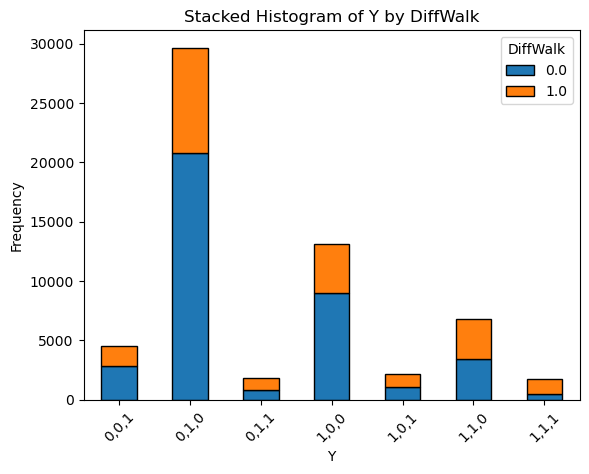

In [382]:
stacked_hist(df, 'Y', 'DiffWalk', drop_Y000=True)

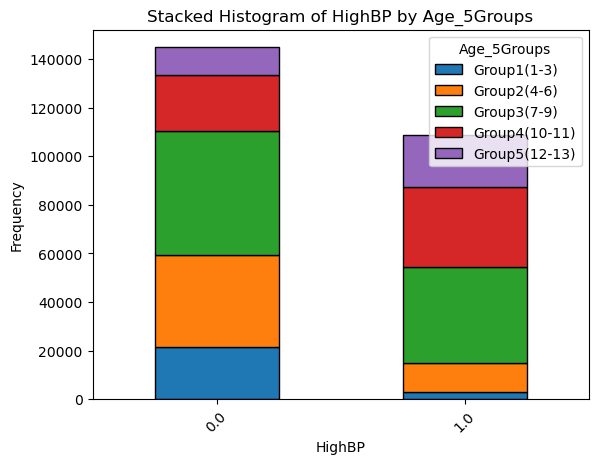

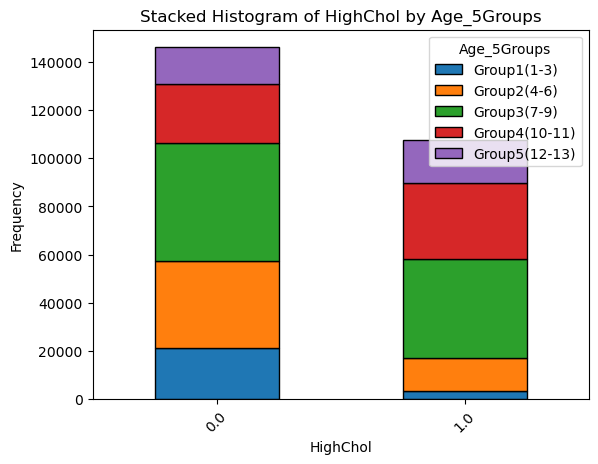

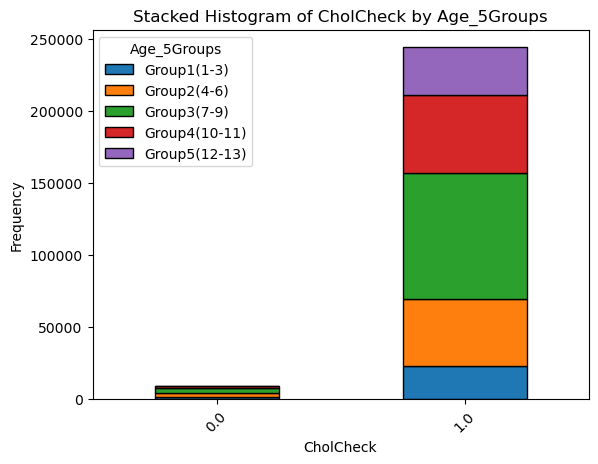

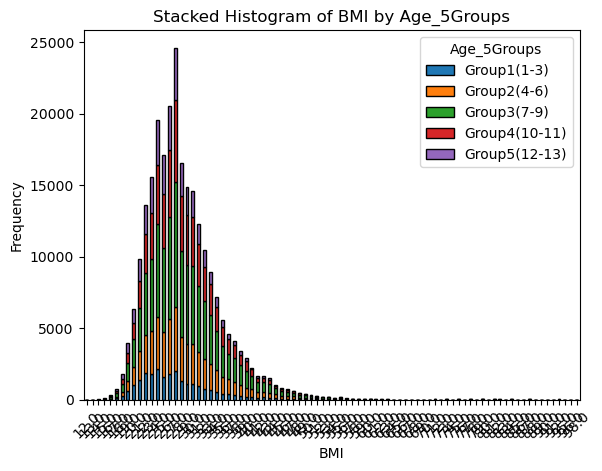

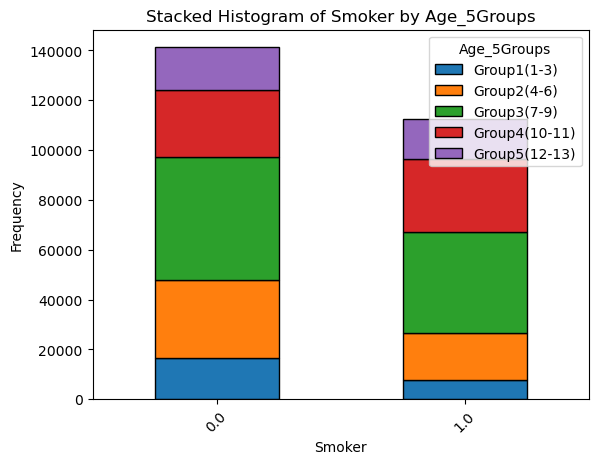

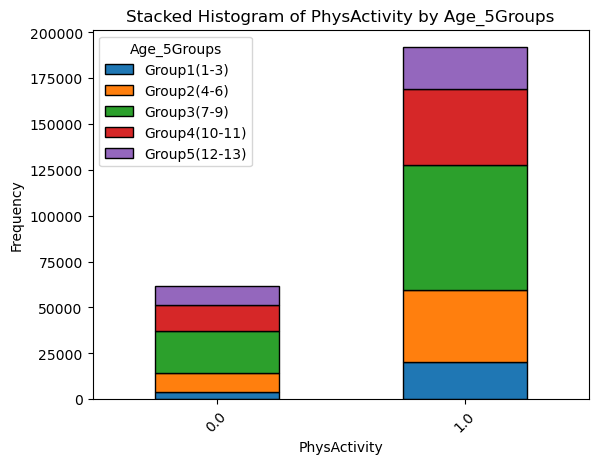

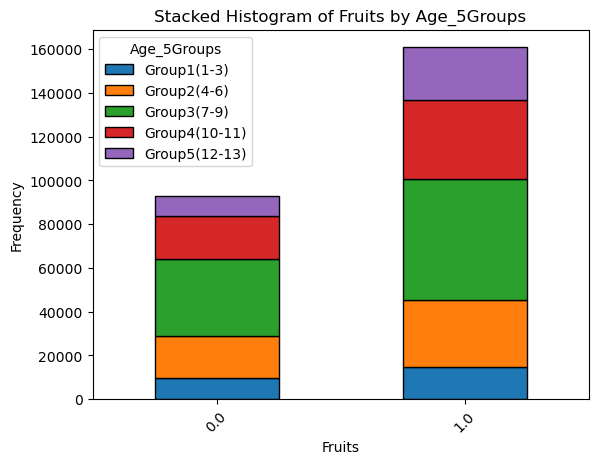

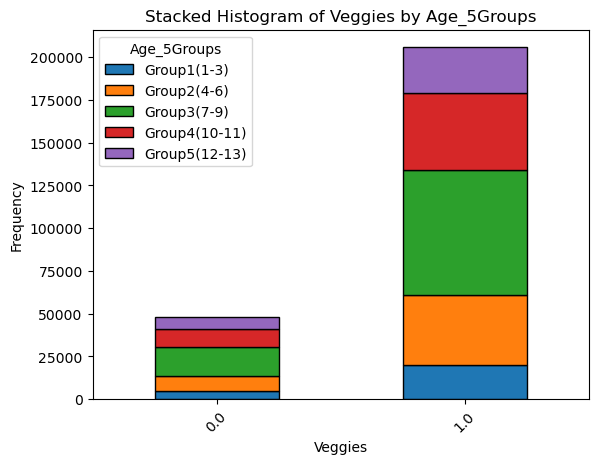

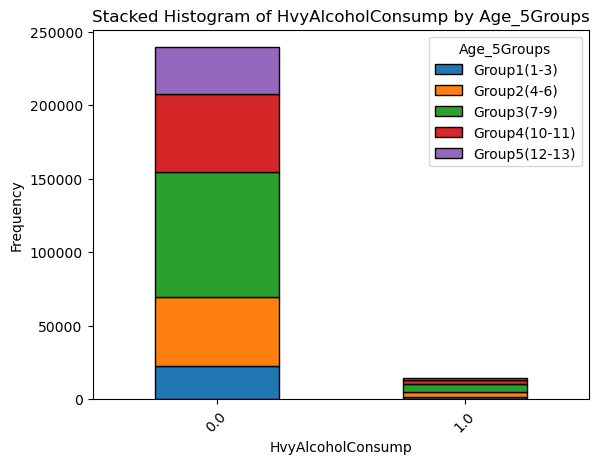

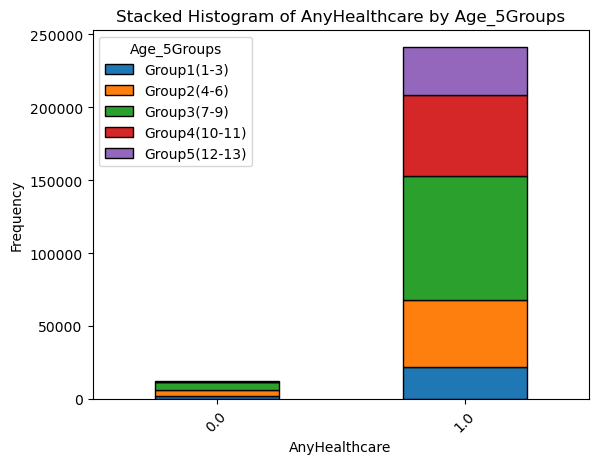

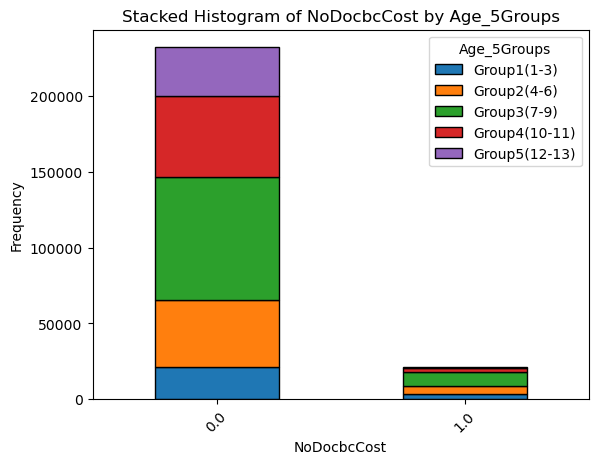

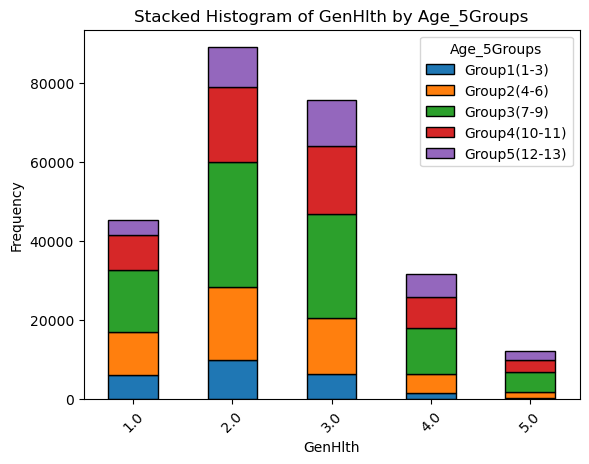

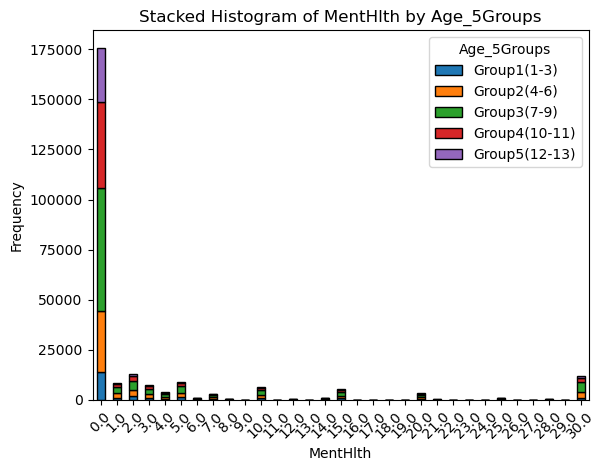

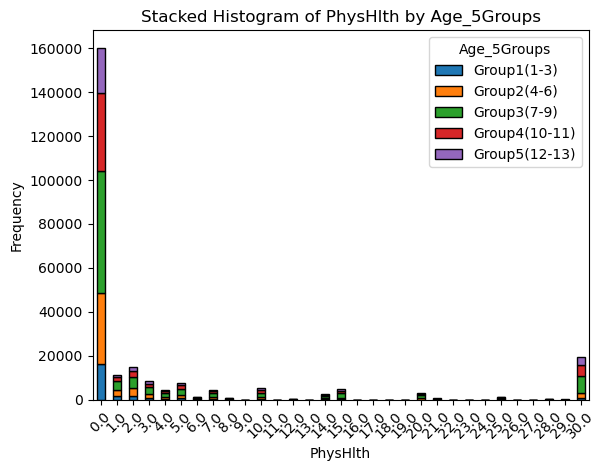

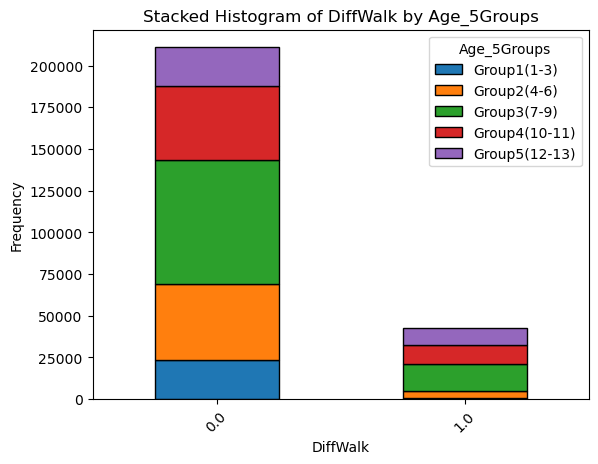

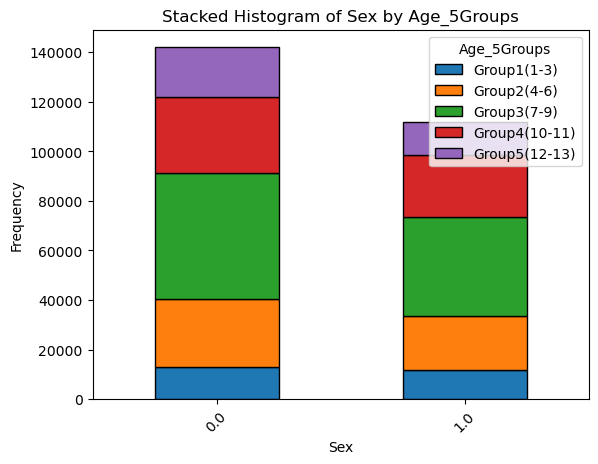

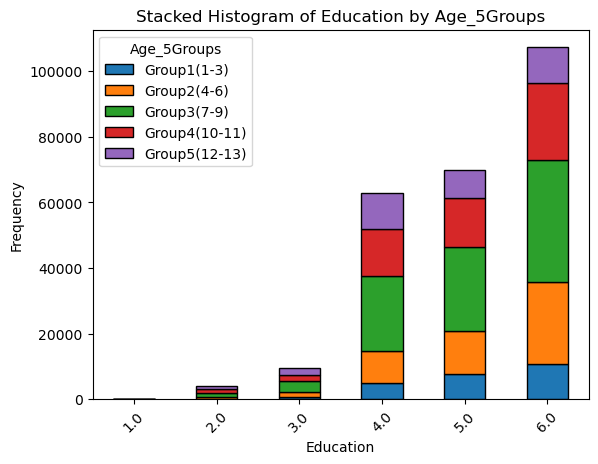

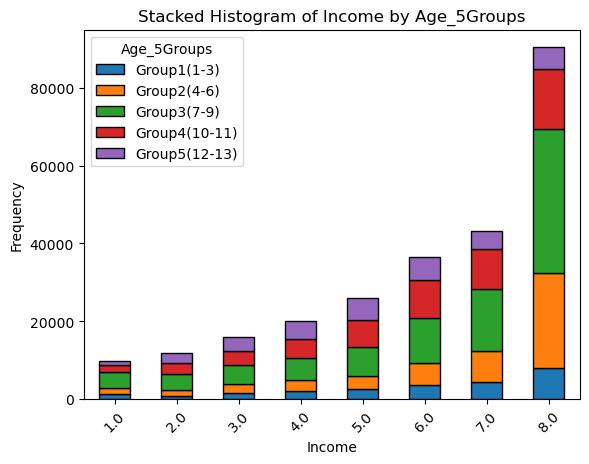

In [398]:
columns_to_drop = ['HeartDiseaseorAttack', 'Diabetes', 'Stroke', 'Y', 'Age', 'Age_5Groups']
feature_names = df.drop(columns=columns_to_drop).columns
for name in feature_names:
    stacked_hist(df, name, 'Age_5Groups')

# Contingency Table

In [392]:
def get_mutual_entropy(df, columnName, drop_Y000=False, merge_Ynot000=False):
    df_copy = df.copy()

    if drop_Y000:
        df_copy = df_copy[df_copy['Y'] != '0,0,0']

    if merge_Ynot000:
        df_copy.loc[df_copy['Y'] != '0,0,0', 'Y'] = '1,1,1'

    contingency_table = pd.crosstab(df_copy[columnName], df_copy['Y'])
    total = contingency_table.values.sum()
    probs = contingency_table.values / total

    conditional_entropy = sum(entropy(prob) * prob.sum() for prob in probs)

    prob_Y = contingency_table.sum(axis=0) / total
    entropy_Y = entropy(prob_Y)

    mutual_entropy = entropy_Y - conditional_entropy
    return mutual_entropy


In [387]:
columns_to_drop = ['HeartDiseaseorAttack', 'Diabetes', 'Stroke', 'Y', 'Age_5Groups', 'Age']
feature_names = df.drop(columns=columns_to_drop).columns
feature_names
mutual_entropy_list = []

for columnName in feature_names:
    mutual_entropy_list.append(get_mutual_entropy(columnName))


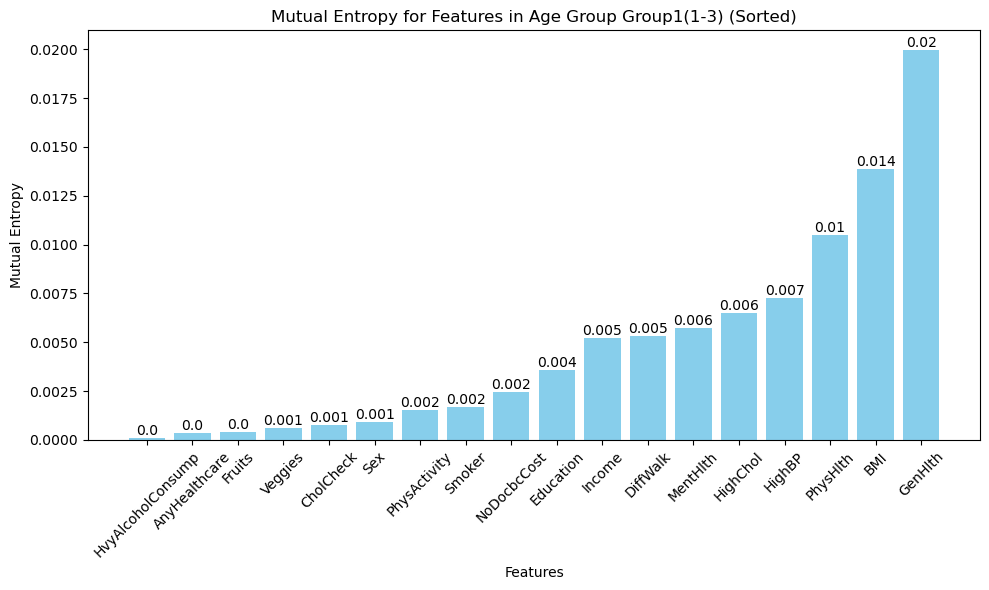

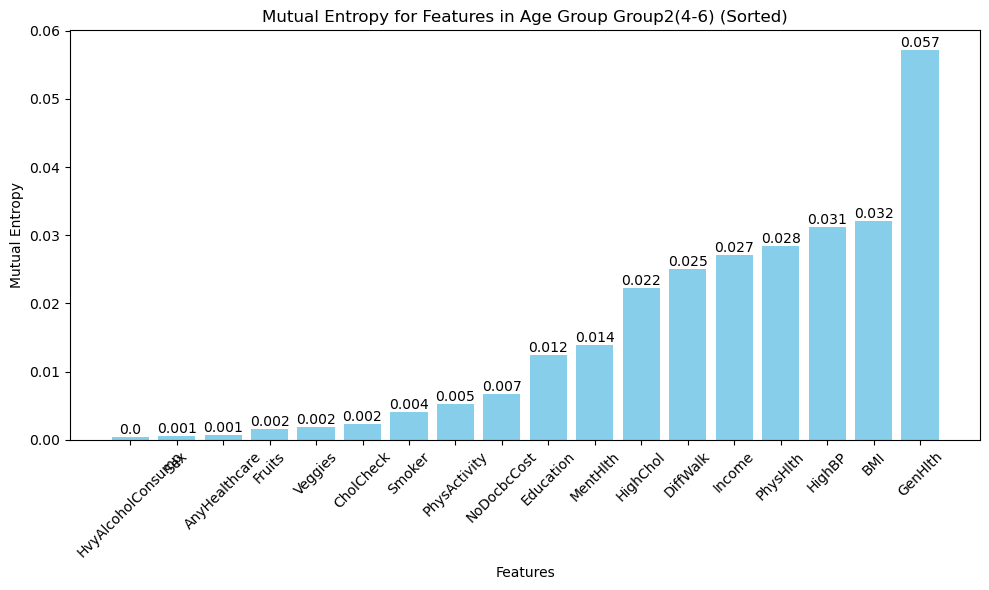

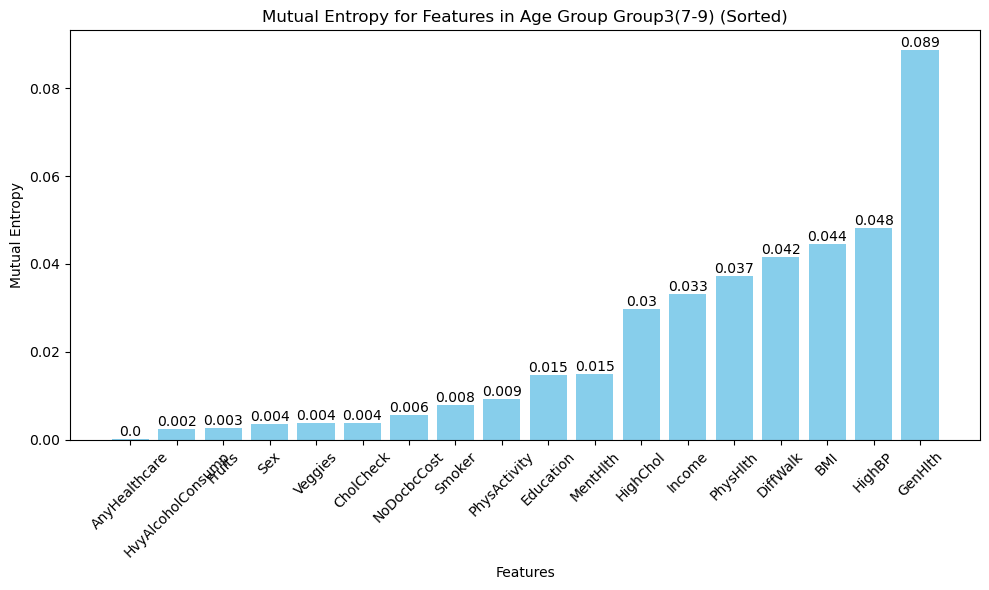

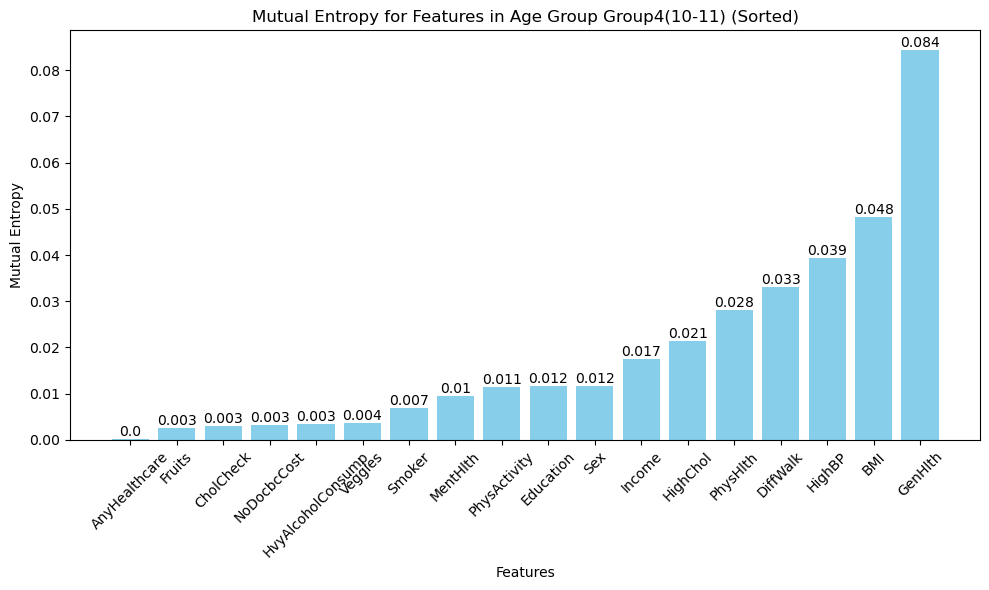

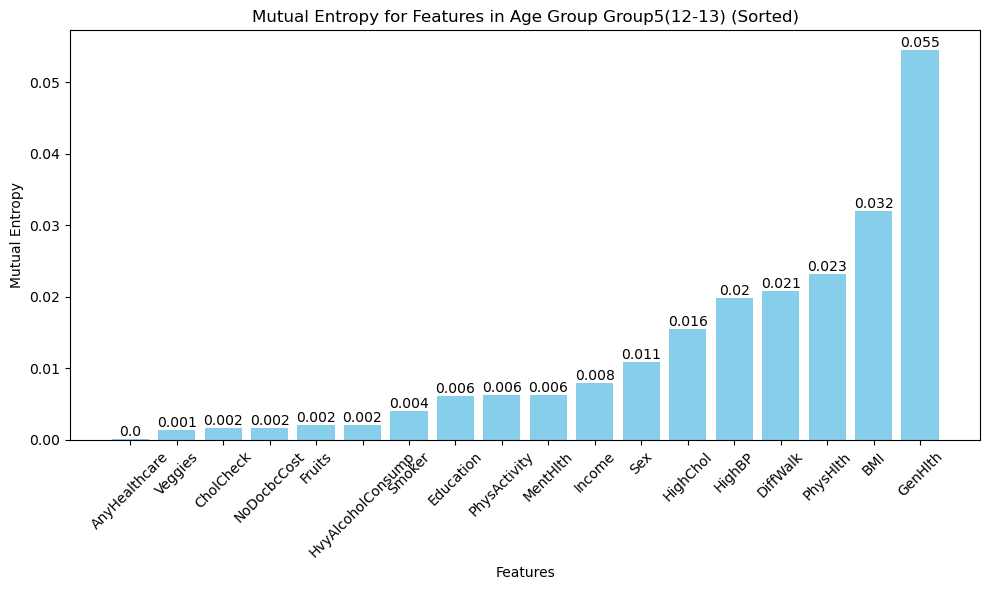

In [397]:
columns_to_drop = ['HeartDiseaseorAttack', 'Diabetes', 'Stroke', 'Y', 'Age', 'Age_5Groups']  # 移除 'Age_5Groups' 以在特征中保留
age_groups = df['Age_5Groups'].unique()  
age_groups = sorted(age_groups)

for age_group in age_groups:
    df_group = df[df['Age_5Groups'] == age_group]
    
    feature_names = df_group.drop(columns=columns_to_drop).columns
    
    mutual_entropy_list = []
    for columnName in feature_names:
        mutual_entropy = get_mutual_entropy(df_group, columnName)  
        mutual_entropy_list.append(mutual_entropy)
    
    features_with_entropy = list(zip(feature_names, mutual_entropy_list))
    sorted_features_with_entropy = sorted(features_with_entropy, key=lambda x: x[1])
    sorted_feature_names, sorted_entropy_list = zip(*sorted_features_with_entropy)

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(sorted_entropy_list)), sorted_entropy_list, color='skyblue')
    plt.xlabel('Features')
    plt.ylabel('Mutual Entropy')
    plt.title(f'Mutual Entropy for Features in Age Group {age_group} (Sorted)')
    plt.xticks(range(len(sorted_entropy_list)), sorted_feature_names, rotation=45)
    plt.tight_layout()
    
    for i, entropy_value in enumerate(sorted_entropy_list):
        plt.text(i, entropy_value, round(entropy_value, 3), ha='center', va='bottom')
    
    plt.show()

In [ ]:
def con_table(columnName, prob=False):
    contingency_table = pd.crosstab(df[columnName], df['Y'])
    print("Contingency Table:")
    print(contingency_table)

    if prob:
        probability_table = contingency_table.div(contingency_table.sum(axis=1), axis=0)
        print("\nProbability Table:")
        print(probability_table)

       

In [263]:
contingency_table = pd.crosstab(df['Sex'], df['Y'])
print("Contingency Table:")
contingency_table

Contingency Table:


Y,"0,0,0","0,0,1","0,1,0","0,1,1","1,0,0","1,0,1","1,1,0","1,1,1"
Sex,,,,,,,,
0.0,111685,2724,16329,1031,5470,1080,2804,851
1.0,82108,1835,13310,765,7681,1120,4001,886
